# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import matplotlib.gridspec as gridspec

In [4]:
# Check for GPU
use_gpu = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_gpu else {}
print("GPU {}".format("Enabled" if use_gpu else "Disabled"))

GPU Disabled


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [5]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [6]:
# Define transforms for the training, validation sets
data_transforms = {
    'training' : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}

# Load the datasets with ImageFolder
image_datasets = {
    'training' : datasets.ImageFolder(train_dir, transform=data_transforms['training']),
    'validation' : datasets.ImageFolder(valid_dir, transform=data_transforms['validation']),
}

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {
    'training' : torch.utils.data.DataLoader(image_datasets['training'], batch_size=64, shuffle=True, **kwargs),
    'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64, shuffle=True, **kwargs),
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [7]:
def get_densenet_model(hidden_units):
    model = models.densenet121(pretrained=True)

   # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier, ensure input and output sizes match
    classifier_input_size = model.classifier.in_features
    classifier_output_size = 102
    
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_units)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_units, classifier_output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    model.classifier = classifier

    return model

In [14]:
model.classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [10]:
def create_model(learning_rate, hidden_units, class_to_idx):
    ''' Create a deep learning model from existing PyTorch model.
    '''
    # Load pre-trained model
    model = get_densenet_model(hidden_units)

    # Set training parameters
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(parameters, lr=learning_rate)
    criterion = nn.NLLLoss()

    # Save class to index mapping
    model.class_to_idx = class_to_idx

    return model, optimizer, criterion

In [13]:
model.class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

In [12]:
# Get class to index mapping
class_to_idx = image_datasets['training'].class_to_idx

# Load pretrained model
hidden_units = 500
learning_rate = 0.001
model, optimizer, criterion = create_model(learning_rate, hidden_units, class_to_idx)

/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [15]:
class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

In [9]:
# Move tensors to GPU if available
if use_gpu:
    model.cuda()
    criterion.cuda()


In [15]:
# Implement a function for the validation pass
def validate_model(model, criterion, data_loader):
    # Put model in inference mode
    model.eval()

    accuracy = 0
    test_loss = 0
    for inputs, labels in iter(data_loader):

        # Set volatile to True so we don't save the history
        if use_gpu:
            inputs = Variable(inputs.float().cuda(), volatile=True)
            labels = Variable(labels.long().cuda(), volatile=True) 
        else:
            inputs = Variable(inputs, volatile=True)
            labels = Variable(labels, volatile=True)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).data[0]

        # Model's output is log-softmax,
        # take exponential to get the probabilities
        ps = torch.exp(output).data

        # Model's output is softmax
        # ps = output.data

        # Class with highest probability is our predicted class, 
        equality = (labels.data == ps.max(1)[1])

        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss/len(data_loader), accuracy/len(data_loader)

In [11]:
def train_model(model, criterion, optimizer, epochs, training_data_loader, validation_data_loader):
    # Ensure model in training mode
    model.train()

    # Train the network using training data
    print_every = 20
    steps = 0

    for epoch in range(epochs):
        running_loss = 0

        # Get inputs and labels from training set
        for inputs, labels in iter(training_data_loader):
            steps += 1

            # Move tensors to GPU if available
            if use_gpu:
                inputs = Variable(inputs.float().cuda())
                labels = Variable(labels.long().cuda()) 
            else:
                inputs = Variable(inputs)
                labels = Variable(labels) 

            # Set gradients to zero
            optimizer.zero_grad()

            # Forward pass to calculate logits
            output = model.forward(inputs)
            
            # Calculate loss (how far is prediction from label)
            loss = criterion(output, labels)

            # Backward pass to calculate gradients
            loss.backward()

            # Update weights using optimizer (add gradients to weights)
            optimizer.step()

            # Track the loss as we are training the network
            running_loss += loss.data[0]

            if steps % print_every == 0:
                validation_loss, accuracy = validate_model(model, criterion, validation_data_loader)

                print("Epoch: {}/{} ".format(epoch+1, epochs),
                        "Training Loss: {:.3f} ".format(running_loss/print_every),
                        "Validation Loss: {:.3f} ".format(validation_loss),
                        "Validation Accuracy: {:.3f}".format(accuracy))

                running_loss = 0

                # Put model back in training mode
                model.train()

In [12]:
# Train the network using traning data
total_epochs = 10
train_model(model, criterion, optimizer, total_epochs, dataloaders['training'], dataloaders['validation'])

/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app
/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/10  Training Loss: 4.343  Validation Loss: 3.917  Validation Accuracy: 0.214
Epoch: 1/10  Training Loss: 3.624  Validation Loss: 3.024  Validation Accuracy: 0.384
Epoch: 1/10  Training Loss: 2.823  Validation Loss: 2.174  Validation Accuracy: 0.545
Epoch: 1/10  Training Loss: 2.204  Validation Loss: 1.618  Validation Accuracy: 0.650
Epoch: 1/10  Training Loss: 1.805  Validation Loss: 1.260  Validation Accuracy: 0.721
Epoch: 2/10  Training Loss: 1.170  Validation Loss: 0.967  Validation Accuracy: 0.775
Epoch: 2/10  Training Loss: 1.213  Validation Loss: 0.821  Validation Accuracy: 0.818
Epoch: 2/10  Training Loss: 1.109  Validation Loss: 0.751  Validation Accuracy: 0.836
Epoch: 2/10  Training Loss: 0.938  Validation Loss: 0.665  Validation Accuracy: 0.858
Epoch: 2/10  Training Loss: 1.011  Validation Loss: 0.590  Validation Accuracy: 0.866
Epoch: 3/10  Training Loss: 0.593  Validation Loss: 0.595  Validation Accuracy: 0.850
Epoch: 3/10  Training Loss: 0.772  Validation Loss: 0.

KeyboardInterrupt: 

In [16]:
# Do validation on the test set
test_loss, accuracy = validate_model(model, criterion, dataloaders['validation'])
print("Validation Accuracy: {:.3f}".format(accuracy))

/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app
/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 0.957


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [30]:
# Saving: feature weights, new classifier, index-to-class mapping, optimiser state, and No. of epochs

# Save the checkpoint 
checkpoint_path = 'densenet121_checkpoint.pth'

state = {
    'arch': 'densenet121',
    'learning_rate': learning_rate,
    'hidden_units': hidden_units,
    'epochs': total_epochs,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'class_to_idx' : model.class_to_idx
}

torch.save(state, checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:
# Loads a checkpoint and rebuild the model
checkpoint_path = 'densenet121_checkpoint.pth'

learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']
# Create pretrained model
model, optimizer, criterion = create_model(learning_rate, hidden_units, class_to_idx)

# Load checkpoint state into model
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

print("Loaded '{}' (arch={}, hidden_units={}, epochs={})".format(
    checkpoint_path, 
    state['arch'], 
    state['hidden_units'], 
    state['epochs']))

# Move tensors to GPU if available
if use_gpu:
    model.cuda()
    criterion.cuda()

Loaded 'densenet121_checkpoint.pth' (arch=densenet121, hidden_units=500, epochs=30)


In [15]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
def resize_image(image, size):
    ''' Resize image so shortest side is 'size' pixels,
        maintain aspect ratio  
    '''
    w, h = image.size
    
    if h > w:
        # Set width to 'size' and scale height to maintain aspect ratio
        h = int(max(h * size / w, 1))
        w = int(size)
    else:
        # Set height to 'size' and scale width to maintain aspect ratio
        w = int(max(w * size / h, 1))
        h = int(size)
        
    return image.resize((w, h))

In [18]:
def crop_image(image, size):
    ''' Return a cropped square region from centre of image
    '''
    w, h = image.size
    x0 = (w - size) / 2
    y0 = (h - size) / 2
    x1 = x0 + size
    y1 = y0 + size
    
    return image.crop((x0, y0, x1, y1))

In [19]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Resize image so shortest side is 256 pixels       
    resized_image = resize_image(image, 256)
    
    # Crop image
    cropped_image = crop_image(resized_image, 224)
    
    # Convert image to float array
    np_image = np.array(cropped_image) / 255.

    # Normalize array
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])     
    np_image = (np_image - mean) / std
        
    # PyTorch tensors assume the color channel is the first dimension
    # but PIL assumes is the third dimension
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

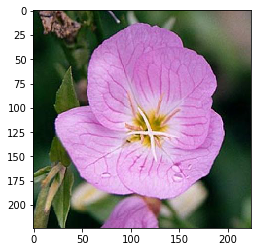

In [18]:
# Check process_image function works as expected...
image_path = train_dir + '/1/image_06734.jpg'
#image_path = train_dir + '/1/image_06735.jpg'
image = Image.open(image_path)
# image.show()

np_array = process_image(image)
tensor = torch.from_numpy(np_array)
imshow(tensor)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [21]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Put model in inference mode
    model.eval()
    
    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)

    # Use GPU if available
    if use_gpu:
        var_inputs = Variable(tensor.float().cuda(), volatile=True)
    else:       
        var_inputs = Variable(tensor, volatile=True)

    # Model is expecting 4d tensor, add another dimension
    var_inputs = var_inputs.unsqueeze(0)
    var_inputs = var_inputs.float()
    # Run image through model
    output = model.forward(var_inputs)  
    
    # Model's output is log-softmax,
    # take exponential to get the probabilities
    ps = torch.exp(output).data.topk(topk)
        
    # Move results to CPU if needed
    probs = ps[0].cpu() if use_gpu else ps[0]
    classes = ps[1].cpu() if use_gpu else ps[1]
           
    # Map classes to indices 
    inverted_class_to_idx = {model.class_to_idx[k]: k for k in model.class_to_idx}
    
    mapped_classes = list()
    for label in classes.numpy()[0]:
        mapped_classes.append(inverted_class_to_idx[label])
     
    # Return results
    return probs.numpy()[0], mapped_classes

In [27]:
# Check predict function works as expected...
image_path = valid_dir + '/28/image_05257.jpg'
probs, classes = predict(image_path, model)

print(probs)
print(classes)

/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


[0.9772478  0.00990351 0.00502201 0.00395312 0.00347853]
['28', '9', '3', '67', '25']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [22]:
def get_title(label):
    try:
        return cat_to_name[label]
    except KeyError:
        return "unknown label"

/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


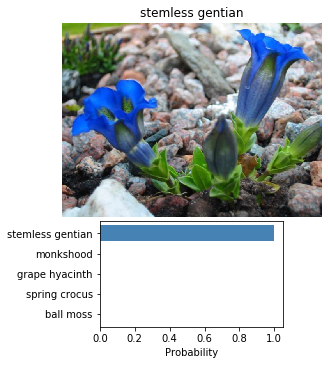

In [23]:
# Get path to test image
image_path = valid_dir + '/28/image_05257.jpg'
#image_path = train_dir + '/1/image_06734.jpg'
#image_path = train_dir + '/1/image_06735.jpg'

# Get top five predictions
probs, classes = predict(image_path, model)
max_index = np.argmax(probs)
max_prob = probs[max_index]
max_label = classes[max_index]

# Create a figure
fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

# Display input image
image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(get_title(max_label))
ax1.imshow(image)

#np_array = process_image(image)
#tensor = torch.from_numpy(np_array)
#imshow(tensor, ax1)

# Display horizontal bar graph with top 5 probabilities
labels = (get_title(e) for e in classes)
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()  # probabilities read top-to-bottom
ax2.set_xlabel('Probability')
ax2.barh(y_pos, probs, xerr=0, align='center', color='steelblue', ecolor='black')

plt.show()